#### Large RAM is required to load the larger models. Running on GPU can optimize inference speed.

In [1]:
import sys
import os
import pandas as pd
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /home/tianyu.han/anaconda3/envs/lavis/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /home/tianyu.han/anaconda3/envs/lavis/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda113.so...


In [3]:
df = pd.read_csv('../../flamingo-mini/data/mimic_impressions_val.csv')
df.head()

,filename,dicom_id,indication,findings,impression
0,50084553.txt,70d7e600-373c1311-929f5ff9-23ee3621-ff551ff9,"___ year old woman with heart failure, dyspnea...",NaN,"Compared to chest radiographs since ___, most ..."
1,51180958.txt,1fa79752-9ddaf5b5-2120ae82-9fec50d6-51f48d1f,Altered mental status and headache. TECHNIQUE:...,No evidence of consolidation to suggest pneumo...,NaN
2,51180958.txt,a8319f39-9eef5bb2-5bd95b97-9dd70b0f-02a846e3,Altered mental status and headache. TECHNIQUE:...,No evidence of consolidation to suggest pneumo...,NaN
3,52139270.txt,489faba7-a9dc5f1d-fd7241d6-9638d855-eaa952b1,NaN,There are moderate bilateral pleural effusions...,"Bilateral pleural effusions, cardiomegaly and ..."
4,52139270.txt,550e6f3b-f008c1d0-8d2dee2a-649b30f4-101a98cc,NaN,There are moderate bilateral pleural effusions...,"Bilateral pleural effusions, cardiomegaly and ..."


#### Load an example image

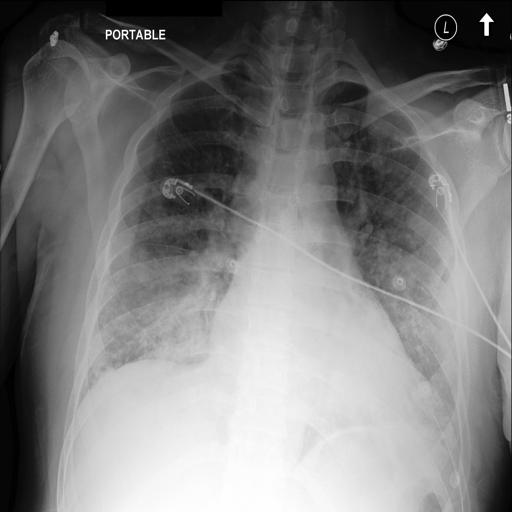

In [11]:
dfs = df.sample(n=1)
img_url = os.path.join('../../Stanford_MIT_CHEST/MIMIC-CXR-v2.0/mimic-cxr/', dfs['dicom_id'].tolist()[0]+'.jpg') 
raw_image = Image.open(img_url).convert('RGB')   
display(raw_image.resize((512, 512)))

In [12]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

#### Load pretrained/finetuned BLIP2 captioning model

In [13]:
# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_t5", model_type="pretrain_flant5xl_vitL", is_eval=True, device=device
)

# Other available models:
# 
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

dict_keys(['train', 'eval'])

#### prepare the image as model input using the associated processors

In [14]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

#### generate caption using beam search

In [15]:
model.generate({"image": image})

['an image of the cardiomediastinal silhouette is mildly enlarged there is no pleural effusion or pneumothorax impression mild']

#### generate multiple captions using nucleus sampling

In [ ]:
# due to the non-determinstic nature of necleus sampling, you may get different captions.
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

#### instructed zero-shot vision-to-language generation

In [17]:
model.generate({"image": image, "prompt": "Question: Is lung opacity appeared in this image? Answer:"})

['an image of no there is no pleural effusion or pneumothorax the cardiomediastinal silhouette is normal there is no acute']

In [19]:
model.generate({
    "image": image,
    "prompt": "Question: the heart size"})

['an image of is within normal limits there is no pleural effusion or pneumothorax there is no acute osseous abnormality impression']

In [21]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: which city is this? Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [27]:
model.generate(
    {
    "image": image,
    "prompt": prompt
    },
    use_nucleus_sampling=False,
)

['merlion is a portmanteau of mermaid and lion']